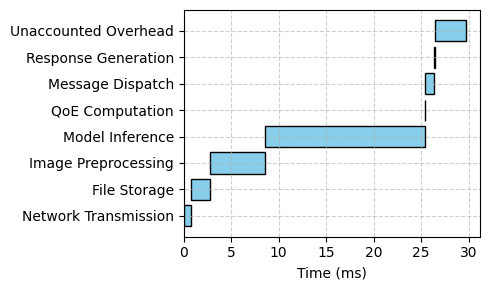

\begin{table} [H]
\centering
\caption{Latency Breakdown ()}
\begin{tabular}{|l|p{2cm}|p{2cm}|}
\hline
\textbf{Component} & \textbf{Latency (ms)} & \textbf{Percent (\%)} \\ \hline
Network Transmission & 0.787 & 2.65 \\ \hline
File Storage & 1.998 & 6.73 \\ \hline
Image Preprocessing & 5.779 & 19.46 \\ \hline
Model Inference & 16.835 & 56.68 \\ \hline
QoE Computation & 0.024 & 0.08 \\ \hline
Message Dispatch & 0.907 & 3.05 \\ \hline
Response Generation & 0.139 & 0.47 \\ \hline
Unaccounted Overhead & 3.234 & 10.89 \\ \hline
\end{tabular}
\end{table}


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_and_visualize_latencies(df):
    # Analyze request latencies
    df["Network Transmission"] = df["network_time"]
    df["File Storage"] = (df["image_save_time"] - df["server_receive_time"]) * 1000
    df["Image Preprocessing"] = (df["image_preprocessed_time"] - df["image_save_time"]) * 1000
    df["Model Inference"] = (df["image_predicted_time"] - df["image_preprocessed_time"]) * 1000
    df["QoE Computation"] = (df["qoe_computed_time"] - df["image_predicted_time"]) * 1000
    df["Message Dispatch"] = (df["event_produced_time"] - df["qoe_computed_time"]) * 1000
    df["Response Generation"] = (df["response_create_time"] - df["event_produced_time"]) * 1000

    # Calculate total processing time
    df["Total"] = (
        df["Network Transmission"] +
        df["File Storage"] +
        df["Image Preprocessing"] +
        df["Model Inference"] +
        df["QoE Computation"] +
        df["Message Dispatch"] +
        df["Response Generation"]
    )

    df["RTT"] = (df["client_receive_time"] - df["client_send_time"]) * 1000
    df["Unaccounted Overhead"] = df["RTT"] - df["Total"]
    df = df[["Network Transmission", "File Storage", "Image Preprocessing", "Model Inference", "QoE Computation", "Message Dispatch", "Response Generation", "Total", "RTT", "Unaccounted Overhead"]]
    # Calculate mean latencies for each component
    results_mean = df.mean().round(3).to_frame().T.drop(columns=["RTT", "Total"])

    # Prepare Gantt chart data
    task_durations = results_mean.iloc[0].to_dict()
    gantt_df = pd.DataFrame.from_dict(task_durations, orient='index', columns=["Duration"])
    gantt_df["Percentage (%)"] = (gantt_df["Duration"] / gantt_df["Duration"].sum()) * 100
    gantt_df["Percentage (%)"] = gantt_df["Percentage (%)"].round(2)

    gantt_df = gantt_df[gantt_df['Duration'] > 0]  # Filter out zero-duration tasks
    gantt_df["Start"] = gantt_df["Duration"].cumsum() - gantt_df["Duration"]
    gantt_df["End"] = gantt_df["Duration"].cumsum()

    # Plot Gantt Chart
    fig, ax = plt.subplots(figsize=(5, 3))
    for task, row in gantt_df.iterrows():
        ax.barh(task, row["Duration"], left=row["Start"], color="skyblue", edgecolor="black")

    ax.set_xlabel("Time (ms)")
    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Generate LaTeX table with Duration and Percentage
    latex_code = ('\\begin{table} [H]\n'
                  '\\centering\n'
                  '\\caption{Latency Breakdown ()}\n'
                  '\\begin{tabular}{|l|p{2cm}|p{2cm}|}\n'
                  '\\hline\n'
                  '\\textbf{Component} & \\textbf{Latency (ms)} & \\textbf{Percent (\%)} \\\\ \\hline\n')

    # Iterate over each row of the DataFrame and add to LaTeX table
    for component, row in gantt_df.iterrows():
        latex_code += f'{component} & {row["Duration"]:.3f} & {row["Percentage (%)"]:.2f} \\\\ \\hline\n'

    # Close the LaTeX table
    latex_code += '\\end{tabular}\n\\end{table}'

    # Show plot and return LaTeX code
    plt.show()
    return latex_code


print(analyze_and_visualize_latencies(pd.read_csv("results.csv")))

In [20]:
df = pd.read_csv("serverless.csv")
df["Image Preprocessing"] = (df["preprocess_time"] - df["start_time"]) * 1000
df["Model Inference"] = (df["predict_time"] - df["preprocess_time"]) * 1000
df.drop(columns=["start_time", "preprocess_time", "predict_time"], inplace=True)
df.mean()

Image Preprocessing    4.762579
Model Inference        8.215444
dtype: float64